# Exploring the Efficient Frontier

In [1]:
#Import Dependencies 
import requests, bs4, re, datetime, os, math, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# User Input
## Grab the User's preferences

To use default preferences, press enter repeatedly

In [2]:
#Regex to recognize dates
dateReg = re.compile(r'(\d\d?)/(\d\d?)/(\d\d\d\d)')
print('For default values, press enter without typing anything for all fields')
#Get User input for date
date = input('What date would you like to begin from? Please input in the form of dd/mm/yy\n')
if date == '':
    date = datetime.date(1980, 12, 31)
else:
    while dateReg.search(date) == None:
        date = input('Error: Please input in the form of dd/mm/yyyy\n')

#Repeat for the ending date
end = input('What date would you like to end at?\nTo choose today leave blank and press enter\n')
if end == '':
    end = datetime.date.today()
else:
    while dateReg.search(end) == None:
        end = input('Error: Please input in the form of dd/mm/yyyy\n')

#Interval Preference
interval = input('What frequency?\nOptions:[1d, 1wk, 1mo]\nDefault option: 1mo\n')

if interval == '':
    interval = '1mo'
else:
    while interval not in ['1d','1wk', '1mo']:
        interval = input('Error:\nYou can only choose from [1d, 1wk, 1mo]\n')
#Tickers
tickers = input('What tickers do you want to scrape?')
if tickers == '':
    tickers = ['KO', 'PFE', 'MRNA', 'T', 'GE', 'F', 'GLD', 'MSFT', 'NVDA', 'MCD']
else:
    tickers = re.compile(r'\w+').findall(tickers)
    
limit = input('What is your MAXIMUM risk tolerance? (The program will find optimal values for all levels of risk up to and including this value)\n')
if limit == '':
    limit = 25
else:
    while re.compile(r'\d+').search(limit) == None:
        limit = input('Error: Please input a number')
limit = int(limit)
xlim = limit


For default values, press enter without typing anything for all fields
What date would you like to begin from? Please input in the form of dd/mm/yy
TSLA GLD NVDA T KO
Error: Please input in the form of dd/mm/yyyy
1/1/2017
What date would you like to end at?
To choose today leave blank and press enter

What frequency?
Options:[1d, 1wk, 1mo]
Default option: 1mo
1wk
What tickers do you want to scrape?TSLA GLD NVDA T KO
What is your MAXIMUM risk tolerance? (The program will find optimal values for all levels of risk up to and including this value)



# Gather and Format data

In [3]:
def scrape(ticker, start, end, interval):
    global DataFrames

    #Convert dates to Datetime Objects
    if start != datetime.date(1980, 12, 31):
        day = int(dateReg.search(start).group(1))
        month = int(dateReg.search(start).group(2))
        year = int(dateReg.search(start).group(3))

        date = datetime.date(year, month, day)
        
    else:
        date = start
        
    if end != datetime.date.today():
        day = int(dateReg.search(end).group(1))
        month = int(dateReg.search(end).group(2))
        year = int(dateReg.search(end).group(3))

        end = datetime.date(year, month, day)

    #Convert dates to Yahoo date-codes

    beginning = datetime.date(1969, 12, 31) #The earliest date offered by Yahoo (Period Zero)
    delta = date - beginning

    startCode = delta.days * 86637
    endCode = startCode + (end - date).days * 86637

    #Pull Data
    url = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={startCode}&period2={endCode}&interval={interval}&events=history&includeAdjustedClose=true'

    file = open('file.csv', 'w')
    res = requests.get(url)
    file.write(res.text)
    file.close()
    df = pd.read_csv('file.csv')
    os.remove('file.csv')

    lst = [0]
    i = 0
    before = df.iloc[0]['Adj Close']
    for row in df.iterrows():
        if i == 0: 
            i += 1
            continue
        change = 100 * ( (row[1]['Adj Close'] - before) / before )
        before = row[1]['Adj Close']
        lst.append(change)
    df['Adj Close'] = lst
    DataFrames.append(df)

In [4]:
#Execute the scrape function and compile into a master DataFrame

DataFrames = []

num = len(tickers)
for tick in tickers:
    try:
        scrape(tick, date, end, interval)
    except Exception as e:
        print(tick)
        print(str(e))
    

master = pd.DataFrame()

exes = []
wais = []
i = 0
for df in DataFrames:
    tick = tickers[i]
    frame = pd.DataFrame(df.set_index('Date')['Adj Close']).rename(columns= {'Adj Close': tick})
    master = master.merge(frame, left_index= True, right_index= True, how= 'outer')
    i += 1

master = master.dropna()
master.applymap(lambda x: str(round(x, 2)) + '%')

,TSLA,GLD,NVDA,T,KO
Date,,,,,
2017-02-13,0.0%,0.0%,0.0%,0.0%,0.0%
2017-02-20,-5.59%,1.72%,-5.38%,2.12%,1.33%
2017-02-27,-2.11%,-1.83%,-2.86%,-0.83%,1.68%
2017-03-06,-3.13%,-2.37%,0.7%,0.81%,-0.45%
2017-03-13,7.31%,1.98%,7.01%,0.61%,-0.61%
...,...,...,...,...,...
2020-11-09,-4.99%,-3.29%,-8.69%,5.36%,8.09%
2020-11-16,19.86%,-0.83%,-1.57%,-2.04%,-1.46%
2020-11-23,19.64%,-4.5%,1.33%,2.51%,0.06%


# Portfolio Analysis
We have generated a master DataFrame with price-change data
We can do classic portfolio analysis now

In [5]:
#Generate covariance matrix
cov = master.cov()
cov

,TSLA,GLD,NVDA,T,KO
TSLA,77.095676,3.979667,19.945981,7.864078,8.514735
GLD,3.979667,3.675083,2.391793,0.677204,1.830441
NVDA,19.945981,2.391793,36.168445,6.720338,5.024954
T,7.864078,0.677204,6.720338,11.095415,6.621913
KO,8.514735,1.830441,5.024954,6.621913,9.938081


Before maximizing returns, we'll find the lowest risk portfolio

In [6]:
#Variance objective function to minimize
def variance(x):
    x = x.reshape(-1, 1)
    new = np.matmul(np.matrix(cov), np.matrix(x))
    return math.sqrt(np.dot(x.reshape(-1), new))
   
        
x = np.array([1/num] * num).reshape(-1, 1)

# Visualization through random simulation

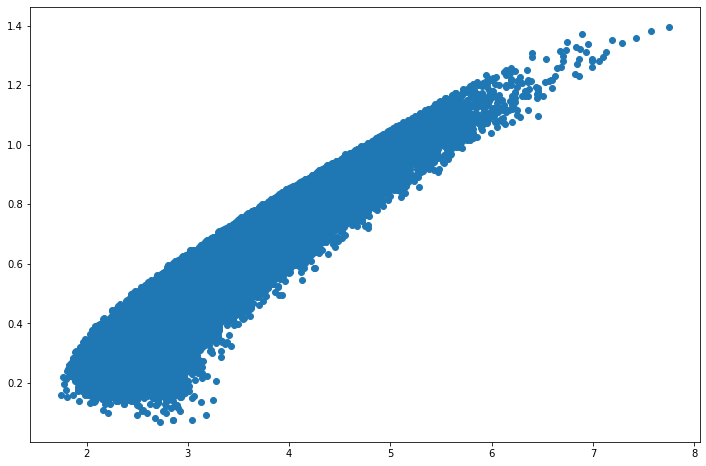

In [7]:
wais = []
exes = []
for _ in range(100000):
    x = np.random.rand(num, 1)
    x = x / np.sum(x)
    ret = np.dot(x.reshape(-1), master.mean())
    var = variance(x)
    exes.append(var)
    wais.append(ret)
   
plt.figure(figsize = (12, 8))
plt.scatter(exes, wais )
# plt.xticks([x for x in range(25)])
# plt.yticks([x for x in range(12)])
plt.show()

## The efficient frontier is beginning to take shape!

Let's find its exact shape with scipy's optimization package

In [8]:
#Define sum(weight) = 1 constraint for inputs
def weightCon(x):
    return 1 - np.sum(x)
constraint1 = {'type': 'eq', 'fun': weightCon}

#Define bounds for each stock's weight
b = (0, 1)
bounds = [b] * num
val = minimize(variance, x, constraints=[constraint1],  method='SLSQP', bounds= bounds)

minVar = val.fun

# Maximizing Returns
We have our minimum amount of risk
Now we know our lower-limit risk tolerance
We can maximize returns for any given variance 

In [9]:
#New Objective Function - Returns
def exRet(x):
    return (np.dot(x.reshape(-1), master.mean())) * -1

#New Constraint
def varCon(x):
    x = x.reshape(-1, 1)
    new = np.matmul(np.matrix(cov), np.matrix(x))
    std = math.sqrt(np.dot(x.reshape(-1), new)) 
    return (std - limit) * -1

constraint2 = {'type': 'ineq', 'fun': varCon}

In [10]:
#Loop through all possible risk tolerances (incrementing by .1) and find their optimal solution

limit = 25
exes = []
wais = []

#weight DataFrame dict
weights = {}
for tick in tickers:
    weights[tick] = []
  

def isIn(lst):
    for elem in lst:
        if round(elem, 2) == 1:
            return True
    return False
switch = 0
for i in range(limit * 10):
    
    #Increment
    limit = limit - .1
    
    #Stop condition
    if limit < minVar:
        break
     
    #Optimize
    val = minimize(exRet, x, constraints= [constraint1, constraint2], bounds= bounds, method= 'SLSQP')
    
    if isIn(val.x):
        continue
        
    else:
        if switch == 0:
            xlim = limit
            switch = 1
            
        
    #Record weights
    for a in range(len(tickers)):
        weights[tickers[a]].append(val.x[a])
    exes.append(limit)
    wais.append(val.fun * -1)
            
#Display Weights over time
weights = pd.DataFrame(weights).iloc[::-1]
weights = weights.reset_index()[tickers]

weights['var'] = exes[::-1]
weights = weights.set_index('var')


weights.applymap(lambda x: str(round(x * 100, 2)) + '%')
      

,TSLA,GLD,NVDA,T,KO
var,,,,,
1.8,1.13%,75.21%,5.25%,10.3%,8.11%
1.9,3.13%,73.95%,7.9%,4.36%,10.67%
2.0,4.71%,72.89%,9.97%,0.0%,12.43%
2.1,6.58%,70.83%,11.85%,0.0%,10.74%
2.2,8.21%,69.05%,13.47%,0.0%,9.27%
...,...,...,...,...,...
8.3,92.46%,0.0%,7.54%,0.0%,0.0%
8.4,94.06%,0.0%,5.94%,0.0%,0.0%
8.5,95.64%,0.0%,4.36%,0.0%,0.0%


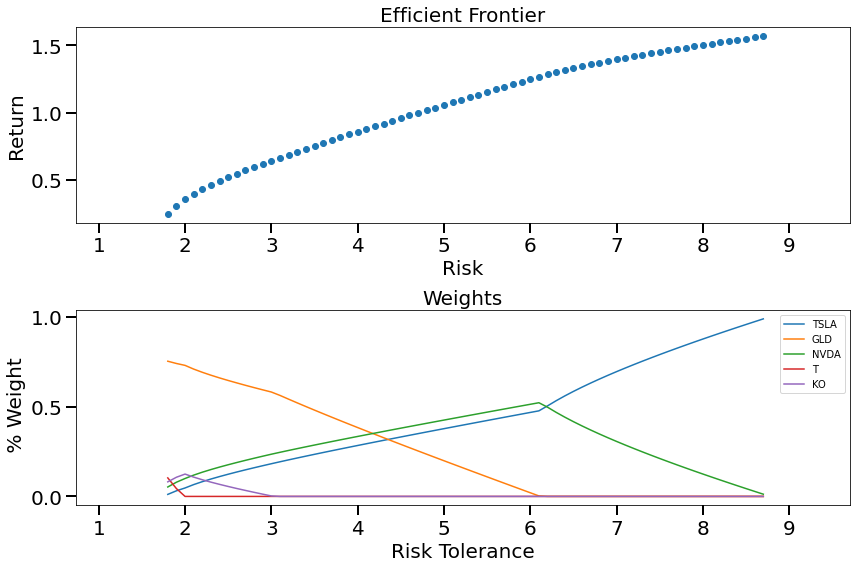

In [17]:
#Generate Plot

fig, axs = plt.subplots(2, figsize=(12, 8), sharex=True)

axs[0].scatter(exes, wais)
axs[0].set_xlabel('Risk', fontsize = 20)
axs[0].set_ylabel('Return', fontsize = 20)

axs[0].tick_params(axis="x", labelsize=20, width = 2, length = 10, labelbottom=True)
axs[0].tick_params(axis="y", labelsize=20, width = 2, length = 10)

axs[0].set_xlim(minVar - 1, xlim + 1)
axs[0].set_title('Efficient Frontier', fontsize=20)

axs[1].plot(weights)
# axs[1].set_xticks(axs[0].get_xticks())
axs[1].legend(weights.columns)
axs[1].set_title('Weights', fontsize= 20)
axs[1].tick_params(axis="x", labelsize=20, width = 2, length = 10)
axs[1].tick_params(axis="y", labelsize=20, width = 2, length = 10)
axs[1].set_xlabel('Risk Tolerance', fontsize = 20)
axs[1].set_ylabel(' % Weight', fontsize = 20)


plt.tight_layout()
plt.show()